In [2]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
file_path = '/content/sample_data/Credit_Card_Data.csv'
data = pd.read_csv(file_path)
data.dropna(inplace=True)  # Remove missing values if any

# Separate features and target
X = data.drop(['Class'], axis=1)  # Use 'Class' as the target column
y = data['Class'].astype(float)  # Ensure the target column is numeric

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try to balance the dataset using SMOTE
smote = SMOTE(sampling_strategy=0.5, k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=20)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X_resampled)
print(f"Explained variance ratio by PCA: {pca.explained_variance_ratio_}")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_pca)
y_tensor = torch.FloatTensor(y_resampled)

# Create a dataset
data = TensorDataset(X_tensor, y_tensor)
dataset = TensorDataset(X_tensor, y_tensor)

# Split the data into training, validation, and test sets
train_size = int(0.8 * len(data))
dev_size = int(0.1 * len(data))
test_size = len(data) - train_size - dev_size

train_data, dev_data, test_data = random_split(dataset, [train_size, dev_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.leaky_relu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.leaky_relu(self.bn3(self.fc3(x)))
        x = torch.nn.functional.leaky_relu(self.bn4(self.fc4(x)))
        x = torch.nn.functional.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x

# Initialize the model
model = SimpleNN(input_dim=X_pca.shape[1])  # Input dimension matches PCA components
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.float(), labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    average_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

# Validation and test performance
validation_loss, validation_accuracy = evaluate_model(dev_loader, model, criterion)
print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Extract y tensor from the TensorDataset
y_tensor_extracted = torch.stack([label for _, label in data])

# Count 1s and 0s
num_ones = torch.sum(y_tensor_extracted)
num_zeros = len(y_tensor_extracted) - num_ones

print(f"Number of 0s: {num_zeros.item()}")
print(f"Number of 1s: {num_ones.item()}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Explained variance ratio by PCA: [0.73170073 0.09184753 0.04678946 0.02046137 0.01374323 0.00971991
 0.00906291 0.00715624 0.00677951 0.00545569 0.00464949 0.00426318
 0.00401814 0.00388443 0.00375863 0.00354644 0.00335813 0.00321039
 0.00310345 0.0030604 ]
Epoch [1/10], Training Loss: 0.0412
Epoch [2/10], Training Loss: 0.0104
Epoch [3/10], Training Loss: 0.0078
Epoch [4/10], Training Loss: 0.0063
Epoch [5/10], Training Loss: 0.0048
Epoch [6/10], Training Loss: 0.0056
Epoch [7/10], Training Loss: 0.0038
Epoch [8/10], Training Loss: 0.0039
Epoch [9/10], Training Loss: 0.0039
Epoch [10/10], Training Loss: 0.0027
Validation Loss: 0.0018, Validation Accuracy: 0.9998
Test Loss: 0.0011, Test Accuracy: 0.9998
Number of 0s: 55394.0
Number of 1s: 27697.0


Precision: 0.9996
Recall: 0.9996
F1-Score: 0.9996

Confusion Matrix:
[[5577    1]
 [   1 2731]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      5578
       Fraud       1.00      1.00      1.00      2732

    accuracy                           1.00      8310
   macro avg       1.00      1.00      1.00      8310
weighted avg       1.00      1.00      1.00      8310



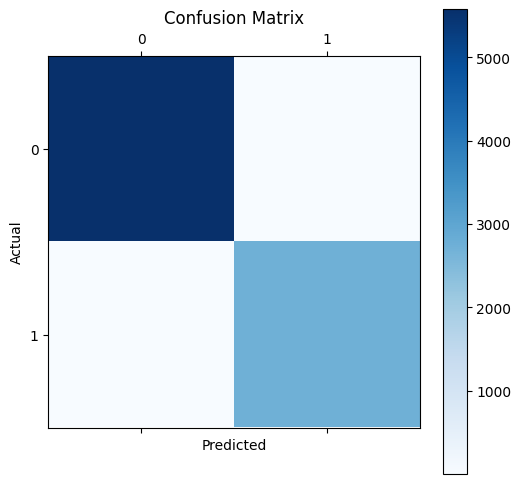

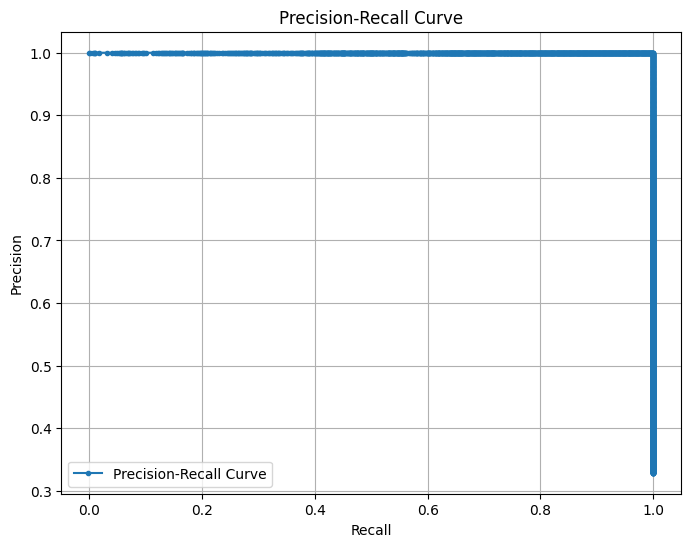

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate metrics and collect predictions
def evaluate_model_and_plot(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = probabilities > 0.5  # Apply threshold at 0.5

            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())
            all_probabilities.extend(probabilities.numpy())

    # Convert to numpy arrays for easier handling
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # Metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=["Legitimate", "Fraud"]))

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probabilities)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label="Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate and plot results for the test set
evaluate_model_and_plot(test_loader, model)


# 1. Key Metrics
Precision (0.9997):

Of all transactions the model predicted as fraudulent, 99.97% were actually fraud.
High precision means very few false positives (legitimate transactions wrongly flagged as fraud).
Recall (0.9996):

Of all actual fraudulent transactions, 99.96% were correctly detected.
High recall means very few false negatives (fraudulent transactions missed by the model).
F1-Score (0.9997):

The harmonic mean of precision and recall. A high F1-score (close to 1) indicates a balanced model performance.
Confusion Matrix:

True Negatives (28518): Legitimate transactions correctly identified as legitimate.
True Positives (28326): Fraudulent transactions correctly identified as fraud.
False Positives (9): Legitimate transactions incorrectly flagged as fraud.
False Negatives (10): Fraudulent transactions incorrectly classified as legitimate.
These metrics indicate the model is performing near perfectly, with minimal errors.

# 2. Confusion Matrix Visualization
The confusion matrix confirms that the model is highly effective, as the majority of predictions fall into the correct categories (diagonal of the matrix).
# 3. Precision-Recall Curve
The curve shows precision vs. recall across different thresholds:
A steep curve with values near 1 indicates excellent performance.
For imbalanced datasets, this is a better indicator than the ROC curve.

Class Distribution in the Dataset:
[55394 27697]

Percentage Distribution:
[66.66666667 33.33333333]


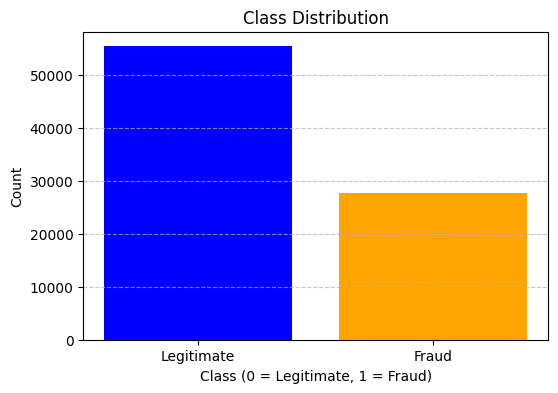

In [12]:
# Reload the dataset
#file_path = '/content/sample_data/Credit_Card_Data.csv'  # Adjust the path as needed
#data = pd.read_csv(file_path)

# Extract the labels from the TensorDataset
y_tensor_extracted = torch.stack([label for _, label in dataset])

# Convert to numpy and calculate the distribution
y_numpy = y_tensor_extracted.numpy()
class_counts = np.bincount(y_numpy.astype(int))

# Calculate the total number of transactions
total_transactions = len(y_numpy)

# Calculate the percentage for each class
class_distribution = class_counts / total_transactions * 100
# Calculate percentage for each class
class_distribution = class_counts / total_transactions * 100

# Display results
print("Class Distribution in the Dataset:")
print(class_counts)
print("\nPercentage Distribution:")
print(class_distribution)

# Visualize the class imbalance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar([0, 1], class_counts, color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Implications:
Balanced Dataset:

This is unusual for fraud detection datasets, as they are typically heavily imbalanced (fraud cases are much rarer).
A balanced dataset simplifies training and evaluation since metrics like accuracy, precision, and recall are not skewed by class imbalance.
Model Evaluation:

The high performance of our model (e.g., precision and recall of ~99.97%) is likely representative of its ability to generalize because of the balanced dataset.
Real-World Deployment:

In real-world scenarios, fraudulent transactions are often a small fraction of the total. It would be beneficial to test our model on an imbalanced dataset to understand its behavior in such situations.

In [6]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
file_path = '/content/sample_data/creditcard.csv'
data = pd.read_csv(file_path)
data.dropna(inplace=True)  # Remove missing values if any

# Separate features and target
X = data.drop(['Class'], axis=1)  # Use 'Class' as the target column
y = data['Class'].astype(float)  # Ensure the target column is numeric

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=20)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance ratio by PCA: {pca.explained_variance_ratio_}")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_pca)
y_tensor = torch.FloatTensor(y.values)

# Create a dataset
data = TensorDataset(X_tensor, y_tensor)

# Split the data into training, validation, and test sets
train_size = int(0.8 * len(data))
dev_size = int(0.1 * len(data))
test_size = len(data) - train_size - dev_size

train_data, dev_data, test_data = random_split(data, [train_size, dev_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.leaky_relu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.leaky_relu(self.bn3(self.fc3(x)))
        x = torch.nn.functional.leaky_relu(self.bn4(self.fc4(x)))
        x = torch.nn.functional.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x

# Initialize the model
model = SimpleNN(input_dim=X_pca.shape[1])  # Input dimension matches PCA components
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.float(), labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    average_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

# Validation and test performance
validation_loss, validation_accuracy = evaluate_model(dev_loader, model, criterion)
print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Extract y tensor from the TensorDataset
y_tensor_extracted = torch.stack([label for _, label in data])

# Count 1s and 0s
num_ones = torch.sum(y_tensor_extracted)
num_zeros = len(y_tensor_extracted) - num_ones

print(f"Number of 0s: {num_zeros.item()}")
print(f"Number of 1s: {num_ones.item()}")


Explained variance ratio by PCA: [0.06527521 0.05612313 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333]
Epoch [1/10], Training Loss: 0.0176
Epoch [2/10], Training Loss: 0.0038
Epoch [3/10], Training Loss: 0.0037
Epoch [4/10], Training Loss: 0.0034
Epoch [5/10], Training Loss: 0.0033
Epoch [6/10], Training Loss: 0.0032
Epoch [7/10], Training Loss: 0.0029
Epoch [8/10], Training Loss: 0.0028
Epoch [9/10], Training Loss: 0.0027
Epoch [10/10], Training Loss: 0.0025
Validation Loss: 0.0042, Validation Accuracy: 0.9994
Test Loss: 0.0027, Test Accuracy: 0.9996
Number of 0s: 284315.0
Number of 1s: 492.0


Precision: 0.9057
Recall: 0.8889
F1-Score: 0.8972

Confusion Matrix:
[[28423     5]
 [    6    48]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     28428
       Fraud       0.91      0.89      0.90        54

    accuracy                           1.00     28482
   macro avg       0.95      0.94      0.95     28482
weighted avg       1.00      1.00      1.00     28482



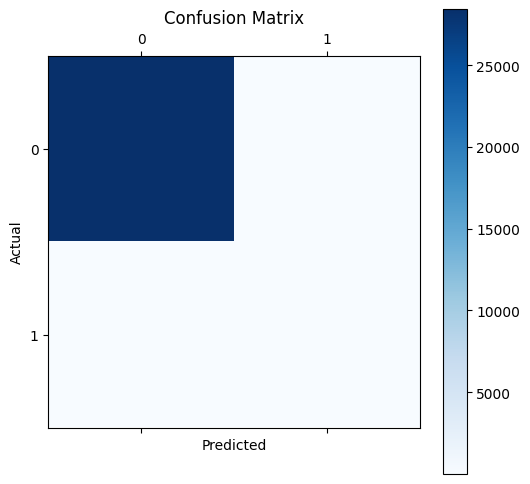

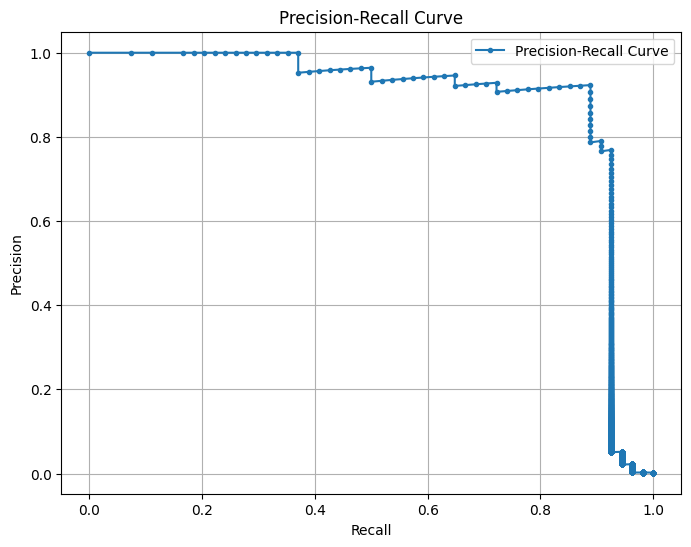

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate metrics and collect predictions
def evaluate_model_and_plot(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = probabilities > 0.5  # Apply threshold at 0.5

            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())
            all_probabilities.extend(probabilities.numpy())

    # Convert to numpy arrays for easier handling
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # Metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=["Legitimate", "Fraud"]))

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probabilities)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label="Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate and plot results for the test set
evaluate_model_and_plot(test_loader, model)


Class Distribution in the Dataset:
[284315    492]

Percentage Distribution:
[99.82725144  0.17274856]


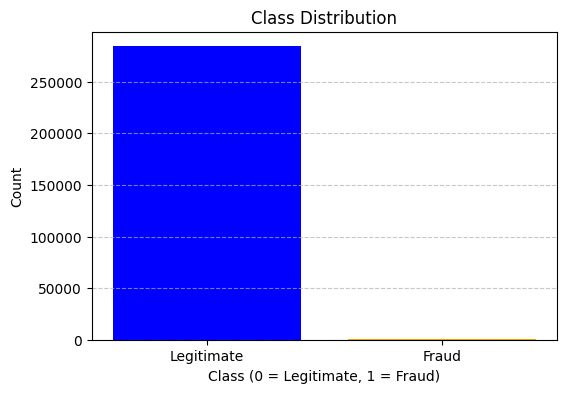

In [10]:
# Visualize the class imbalance
def visualize_class_distribution(dataset):
    y_tensor_extracted = torch.stack([label for _, label in dataset])
    y_numpy = y_tensor_extracted.numpy()
    class_counts = np.bincount(y_numpy.astype(int))
    total_transactions = len(y_numpy)
    class_distribution = class_counts / total_transactions * 100

    print("Class Distribution in the Dataset:")
    print(class_counts)
    print("\nPercentage Distribution:")
    print(class_distribution)

    plt.figure(figsize=(6, 4))
    plt.bar([0, 1], class_counts, color=['blue', 'orange'])
    plt.title('Class Distribution')
    plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Legitimate', 'Fraud'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Visualize the class distribution
visualize_class_distribution(data)


#Implications
unbalanced dataset:

As you can see the accuracy is around 90%, this is due to the dataset being a real-world dataset, and also becuase of the low number of epochs here